# Supervised Learning

# 05_supervised_learning_model

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 30/10/2025   | Martin | Created   | Notebook created for supervised learning model | 
| 01/10/2025   | Martin | New   | Added XGBoost and FFNN sections | 
| 05/10/2025   | Martin | Updated   | Tested on dummy target class. FF NN just tested | 
| 06/10/2025   | Martin | New   | Added section for feature importance and model inspection | 
| 11/10/2025   | Martin | New   | Added section for training curves | 
| 12/10/2025   | Martin | New   | Added section for sensitivity analysis. Updated feature importance section with "removed" model | 
| 13/10/2025   | Martin | New   | Reran on updated dataset. Completed failure analysis for single instance | 
| 16/10/2025   | Martin | Update   | Reran on updated dataset | 
| 17/10/2025   | Martin | Update   | Added new plot to failure analysis | 

# Content

* [Introduction](#introduction)
* [Load Data](#load-data)
* [Cost List](#cost-list)
* [Supervised Learning Models](#supervised-learning-models)
* [Feature Importance & Model Inspection](#feature-importance--model-inspection)
* [Training Curves](#training-curves)
* [Sensitivity Analysis](#sensitivity-analysis)
* [Failure Analysis](#failure-analysis)

# Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# Load Data

In [2]:
path = "../data/outputs"
df = pd.read_pickle(f"{path}/df_unsupervised_final.pkl")

In [3]:
df.head()

,gender,age,number_of_claims,preventative_care_ind,G9857,G9708,S0605,G0153,G0464,G0155,...,HCPCS_level_1,HCPCS_level_2,National_Codes_Established_for_State_Medicaid_Agencies,Evaluation_and_Management_(E/M)_Codes_,Temporary_Codes,Temporary_National_Codes_(Non-Medicare),Procedures/Professional_Services,Alcohol_and_Drug_Abuse_Treatment,Outpatient_PPS,cluster
0,0,79.0,18,1,0.0,0.0,0.0,0.0,0.279341,0.0,...,0.665558,0.746346,0.0,0.665558,0.0,0.0,0.746346,0.0,0.0,1
1,1,75.0,17,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.892770,0.450512,0.0,0.892770,0.0,0.0,0.450512,0.0,0.0,1
2,0,77.0,29,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.938776,0.344529,0.0,0.938776,0.0,0.0,0.344529,0.0,0.0,1
3,0,78.0,24,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.855392,0.517980,0.0,0.855392,0.0,0.0,0.517980,0.0,0.0,1
4,1,80.0,19,1,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.313617,0.949550,0.0,0.313617,0.0,0.0,0.949550,0.0,0.0,1


# Cost List

Get the cost of procedures from claims with single HCPCS based on the existing claims list

In [4]:
df_patient = pd.read_pickle("../data/clean/patient_level.pkl")

In [5]:
def get_price_list_from_hcpcs(df: pd.DataFrame, price_selection: str):
  """Retrieve the price of each HCPCS code from those claims that only have 1 code

  Args:
      df (pd.DataFrame): Patient Level dataset
      price_selection (str): Any aggregation function for group by ("max", "min", "mean"). 
          How to handle when multiple claims have the same singular code

  Returns:
      pd.DataFrame: Cost of each HCPCS
  """
  temp = df.copy()
  temp['hcpcs_len'] = temp['combined_hcpcs_ls'].str.len()

  # Get only those with single HCPC values
  cost = temp[temp['hcpcs_len'] == 1]

  # Only the select only the hcpcs codes and total bill
  cost['hcpcs_code'] = cost['combined_hcpcs_ls'].str[0]
  cost = cost[['hcpcs_code', 'total_value']]

  # Based on cost selection
  cost = cost.groupby('hcpcs_code').agg(price_selection)
  cost['total_value'] = np.round(cost['total_value'], 2)
  cost = cost.reset_index()
  cost = cost.rename({
    'total_value': 'cost'
  }, axis=1)

  return cost

In [6]:
cost = get_price_list_from_hcpcs(df_patient, price_selection='mean')

In [7]:
cost

,hcpcs_code,cost


# Supervised Learning Models

Assumption: All the data is already numerically encoded

## Additional data processing

In [4]:
SEED = 43

df = df.rename({
  'cluster': 'target'
}, axis=1)
df['preventative_care_ind'] = df['preventative_care_ind'].astype(int)

## Split Data

Create train, validation and test splits in __stratified__ manner

- Train: 80%
- Validation: 10%
- Test: 10%

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
# Change split values here
train_size = 0.8
test_size = 0.5

In [7]:
y = df['target']
train, temp = train_test_split(df, train_size=train_size, stratify=y, random_state=SEED)
val, test = train_test_split(temp, train_size=test_size, stratify=temp['target'], random_state=SEED)

In [8]:
print("---------- Number of Entries in each Set ----------")
print(f"Train: {train.shape}")
print(f"Validation: {val.shape}")
print(f"Test: {test.shape}")

---------- Number of Entries in each Set ----------
Train: (2085, 58)
Validation: (261, 58)
Test: (261, 58)


In [9]:
strat = pd.concat([train, val], axis=0).reset_index(drop=True)
y_strat = strat['target']
X_strat = strat.drop('target', axis=1)

In [10]:
y_train = train['target']
X_train = train.drop('target', axis=1)

y_val = val['target']
X_val = val.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)

## Metrics

Common classification metrics:

- Accuracy
- Precision (weighted)
- Recall (weighted)
- F1 Score (weighted)

NOTE: Some metrics weighted by the support (number of true instances for each label) since this is a multi-class problem. This ensures that imbalanced data is accounted for.

Plots:

- Confusion Matrix

In [13]:
def metrics_score(y_true: list, y_pred: list):
  """Takes a series of true and predicted labels and returns their
  - Accuracy
  - Precision (weighted)
  - Recall (weighted)
  - F1 Score (weighted)

  Args:
      y_true (pd.Series | list): Actual labels
      y_pred (pd.Series | list): Predicted Labels

  Returns:
      acc, prec, recall, f1: Metric scores
  """
  acc = round(accuracy_score(y_true, y_pred), 4)
  prec = round(precision_score(y_true, y_pred, average='weighted'), 4)
  recall = round(recall_score(y_true, y_pred, average='weighted'), 4)
  f1 = round(f1_score(y_true, y_pred, average="weighted"), 4)

  return acc, prec, recall, f1

In [14]:
def plot_confusion_matrix(y_true: list, y_pred: list, clf):
  """Plots a confusion matrix given a classification model and the true labels

  Args:
      y_true (pd.Series | list): Actual labels
      y_pred (pd.Series | list): Predicted Labels
      clf (model object): classification model
  """
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=clf.classes_
  )

  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [15]:
def plot_folds(model_results: dict, title: str):
  """Plots a bar graph of results from all folds

  Args:
      model_results (dict): Dictionary containing fold results
      title (str): Title of the plot
  """
  # Add the average across all folds
  model_results['folds'].append("average")
  model_results['accuracy'].append(np.mean(model_results['accuracy']))
  model_results['precision'].append(np.mean(model_results['precision']))
  model_results['recall'].append(np.mean(model_results['recall']))
  model_results['f1'].append(np.mean(model_results['f1']))

  # Split results
  folds = model_results['folds']
  del model_results['folds']


  # Plot graph
  x = np.arange(len(folds))
  width = 0.15
  multiplier = 0

  fig, ax = plt.subplots(layout="constrained")
  for attribute, measurement in model_results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
  
  ax.set_ylabel("Score (%)")
  ax.set_xlabel("Fold")
  ax.set_title(title)
  ax.set_xticks(x + width, folds)
  ax.legend(loc="upper left")
  plt.show()

## Baseline: Dummy Classifier

Uses sklearns dummy classifier to test various baseline strategies

In [18]:
strategy = "most_frequent"

In [19]:
dummy_clf = DummyClassifier(strategy=strategy)
dummy_clf.fit(X_train, y_train)

preds = dummy_clf.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 51.339999999999996%
Precision: 26.36%
Recall: 51.339999999999996%
F1: 34.83%


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


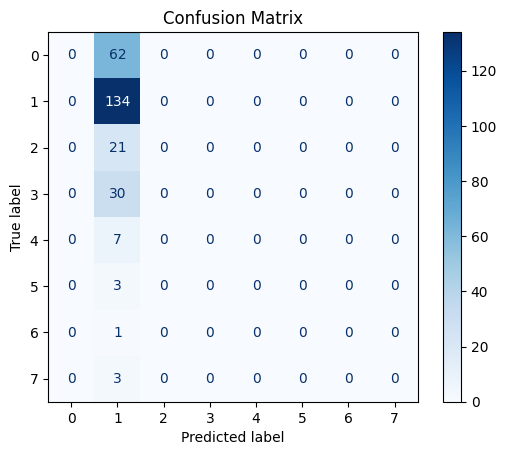

In [20]:
plot_confusion_matrix(y_val, preds, dummy_clf)

## Model 1: Logistic Regression

Simple logistic regression model for an improved baseline

In [21]:
lr_model = OneVsRestClassifier(LogisticRegression(random_state=SEED))
# lr_model = OneVsOneClassifier(LogisticRegression(random_state=SEED))

lr_model.fit(X_train, y_train)
preds = lr_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 97.32%
Precision: 97.0%
Recall: 97.32%
F1: 97.06%


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.or

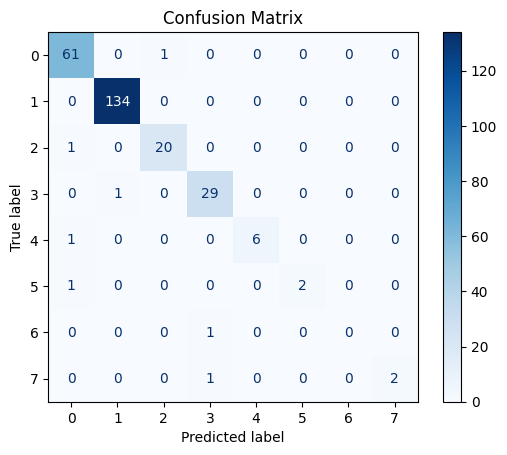

In [22]:
plot_confusion_matrix(y_val, preds, lr_model)

In [23]:
# For K-Fold shuffled stratified cross validation
results = {
  "folds": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
lr_model = OneVsRestClassifier(LogisticRegression(random_state=SEED, max_iter=300))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  lr_model.fit(X_strat_train, y_strat_train)

  preds = lr_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")

  # Adding results
  results['folds'].append(str(split_idx))
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)

/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.or


========== Split 0 ==========
Accuracy: 96.81%
Precision: 96.87%
Recall: 96.81%
F1: 96.64%

========== Split 1 ==========
Accuracy: 96.17%
Precision: 95.93%
Recall: 96.17%
F1: 95.7%

========== Split 2 ==========


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv

Accuracy: 97.87%
Precision: 97.49%
Recall: 97.87%
F1: 97.63%

========== Split 3 ==========
Accuracy: 96.81%
Precision: 96.48%
Recall: 96.81%
F1: 96.47%

========== Split 4 ==========


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv

Accuracy: 96.17%
Precision: 95.89%
Recall: 96.17%
F1: 95.78%

========== Split 5 ==========


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martz/Repos/siads_696_mII/.venv

Accuracy: 96.17%
Precision: 96.3%
Recall: 96.17%
F1: 95.95%

========== Split 6 ==========
Accuracy: 97.45%
Precision: 97.49%
Recall: 97.45%
F1: 97.31%

========== Split 7 ==========
Accuracy: 96.17%
Precision: 96.33%
Recall: 96.17%
F1: 95.97%

========== Split 8 ==========


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv

Accuracy: 97.02%
Precision: 96.67%
Recall: 97.02%
F1: 96.74000000000001%

========== Split 9 ==========
Accuracy: 97.45%
Precision: 97.48%
Recall: 97.45%
F1: 97.38%


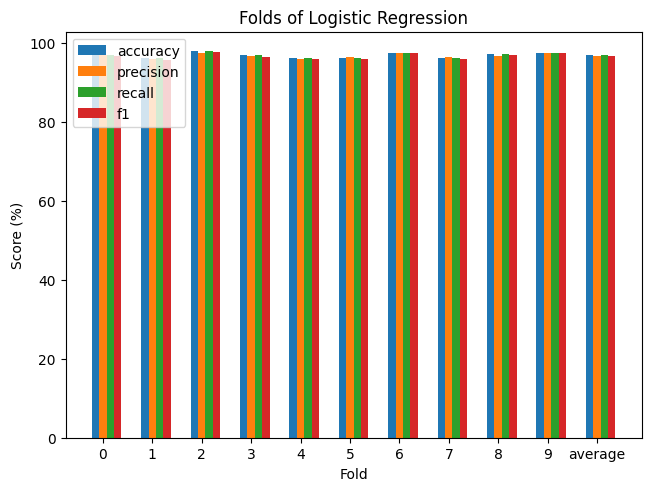

In [24]:
plot_folds(results, "Folds of Logistic Regression")

## Model 2: Decision Tree / Random Forest

Similar reason for decision tree except more interpretable. Random forest for boosting improvements

In [25]:
# For model tuning
config = {
  "max_depth": 10,
  "min_samples_split": 2,
  "min_samples_leaf": 1
}

In [26]:
dt_model = DecisionTreeClassifier(**config, random_state=SEED)

dt_model.fit(X_train, y_train)
preds = dt_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 94.25%
Precision: 93.97%
Recall: 94.25%
F1: 94.05%


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


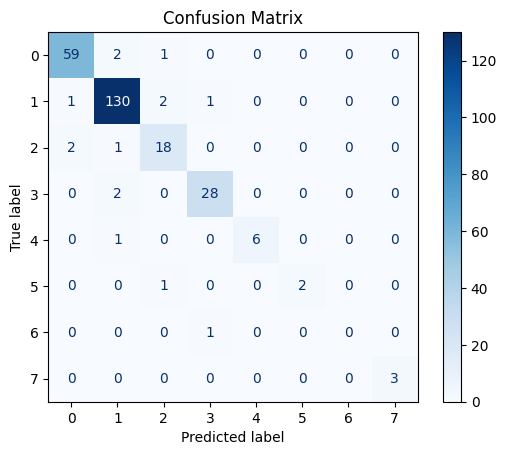

In [27]:
plot_confusion_matrix(y_val, preds, dt_model)

In [28]:
# For K-Fold shuffled stratified cross validation
results = {
  "folds": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
dt_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  dt_model.fit(X_strat_train, y_strat_train)

  preds = dt_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")

  # Adding results
  results['folds'].append(str(split_idx))
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)


========== Split 0 ==========
Accuracy: 93.83%
Precision: 96.27%
Recall: 93.83%
F1: 94.71000000000001%

========== Split 1 ==========
Accuracy: 93.83%
Precision: 96.61999999999999%
Recall: 93.83%
F1: 94.91000000000001%

========== Split 2 ==========
Accuracy: 96.81%
Precision: 97.61%
Recall: 96.81%
F1: 97.05%

========== Split 3 ==========
Accuracy: 93.83%
Precision: 96.78%
Recall: 93.83%
F1: 94.83%

========== Split 4 ==========
Accuracy: 95.11%
Precision: 96.26%
Recall: 95.11%
F1: 95.35%

========== Split 5 ==========
Accuracy: 92.55%
Precision: 95.50999999999999%
Recall: 92.55%
F1: 93.69%

========== Split 6 ==========
Accuracy: 95.96000000000001%
Precision: 98.41%
Recall: 95.96000000000001%
F1: 96.87%

========== Split 7 ==========
Accuracy: 94.26%
Precision: 95.86%
Recall: 94.26%
F1: 94.83%

========== Split 8 ==========
Accuracy: 92.97999999999999%
Precision: 95.21%
Recall: 92.97999999999999%
F1: 93.71000000000001%

========== Split 9 ==========
Accuracy: 95.32000000000001%
Prec

/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


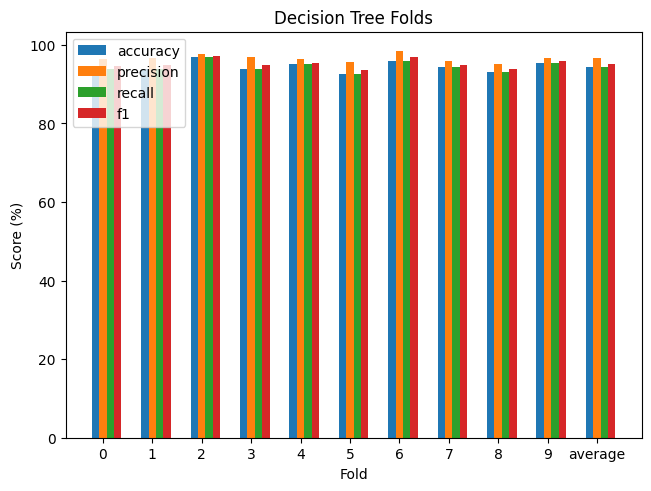

In [29]:
plot_folds(results, "Decision Tree Folds")

Random Forest Classifier

In [30]:
# For model tuning
config = {
  "n_estimators": 100,
  "max_depth": None,
  "min_samples_split": 2,
  "min_samples_leaf": 1
}

In [31]:
rf_model = RandomForestClassifier(**config, random_state=SEED)

rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 96.17%
Precision: 95.91%
Recall: 96.17%
F1: 95.93%


/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [32]:
# For K-Fold shuffled stratified cross validation
results = {
  "folds": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=SEED)
rf_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))

for split_idx, (train_idx, test_idx) in enumerate(sss.split(X_strat, y_strat)):
  print(f"\n========== Split {split_idx} ==========")

  X_strat_train, X_strat_val = X_strat.iloc[train_idx], X_strat.iloc[test_idx]
  y_strat_train, y_strat_val = y_strat[train_idx], y_strat[test_idx]

  rf_model.fit(X_strat_train, y_strat_train)

  preds = rf_model.predict(X_strat_val)
  acc, prec, recall, f1 = metrics_score(y_strat_val, preds)
  print(f"Accuracy: {acc * 100}%")
  print(f"Precision: {prec * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1: {f1 * 100}%")

  # Adding results
  results['folds'].append(str(split_idx))
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)


========== Split 0 ==========
Accuracy: 93.83%
Precision: 96.27%
Recall: 93.83%
F1: 94.71000000000001%

========== Split 1 ==========
Accuracy: 93.83%
Precision: 96.61999999999999%
Recall: 93.83%
F1: 94.91000000000001%

========== Split 2 ==========
Accuracy: 96.81%
Precision: 97.61%
Recall: 96.81%
F1: 97.05%

========== Split 3 ==========
Accuracy: 93.83%
Precision: 96.78%
Recall: 93.83%
F1: 94.83%

========== Split 4 ==========
Accuracy: 95.11%
Precision: 96.26%
Recall: 95.11%
F1: 95.35%

========== Split 5 ==========
Accuracy: 92.55%
Precision: 95.50999999999999%
Recall: 92.55%
F1: 93.69%

========== Split 6 ==========
Accuracy: 95.96000000000001%
Precision: 98.41%
Recall: 95.96000000000001%
F1: 96.87%

========== Split 7 ==========
Accuracy: 94.26%
Precision: 95.86%
Recall: 94.26%
F1: 94.83%

========== Split 8 ==========
Accuracy: 92.97999999999999%
Precision: 95.21%
Recall: 92.97999999999999%
F1: 93.71000000000001%

========== Split 9 ==========
Accuracy: 95.32000000000001%
Prec

/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


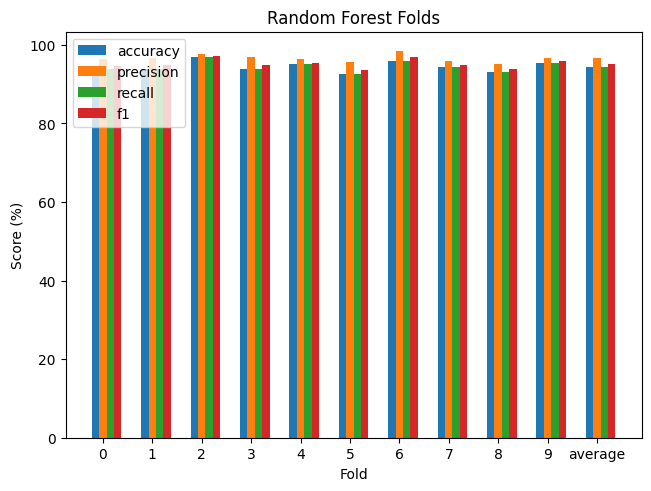

In [33]:
plot_folds(results, "Random Forest Folds")

## Model 3: XGBoost

Larger improvement over standard decision tree and random forest

In [11]:
config = {
  "num_class": 8,
  "n_estimators": 100,
  "max_depth": 2,
  "learning_rate": 1
}

In [16]:
xgb_model = XGBClassifier(**config, objective="multi:softmax", random_state=SEED)

xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_val)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 98.08%
Precision: 98.1%
Recall: 98.08%
F1: 98.04%


Feature importance metrics in XGBoost Trees:

- `gain` - A measure of the improvement in model performance or reduction in loss achieved by using a specific feature to split a node in a decision tree
- `weight` - The number of times a feature is used to split the data across all trees

In [36]:
def plot_xgb_importance(data: dict, title: str):
  """Plots the feature importance for XGB model

  Args:
      data (dict): Feature importance results from XGB model
      title (str): Title for plot
  """
  sorted_data = dict(sorted(data.items(), key=lambda x: x[1]))

  features = list(sorted_data.keys())
  scores = list(sorted_data.values())

  # Plot importance graph
  fig, ax = plt.subplots(figsize=(10, 10))
  bars = ax.barh(features, scores)

  for bar in bars:
    width = bar.get_width()
    label = f"{width:.3f}"
    ax.text(
      width,
      bar.get_y() + bar.get_height() / 2,
      label,
      ha='left',
      va='center',
      fontsize=9,
    )
  
  ax.set_xlabel("Importance Score")
  ax.set_ylabel("Features")
  ax.set_title(title)
  plt.tight_layout()

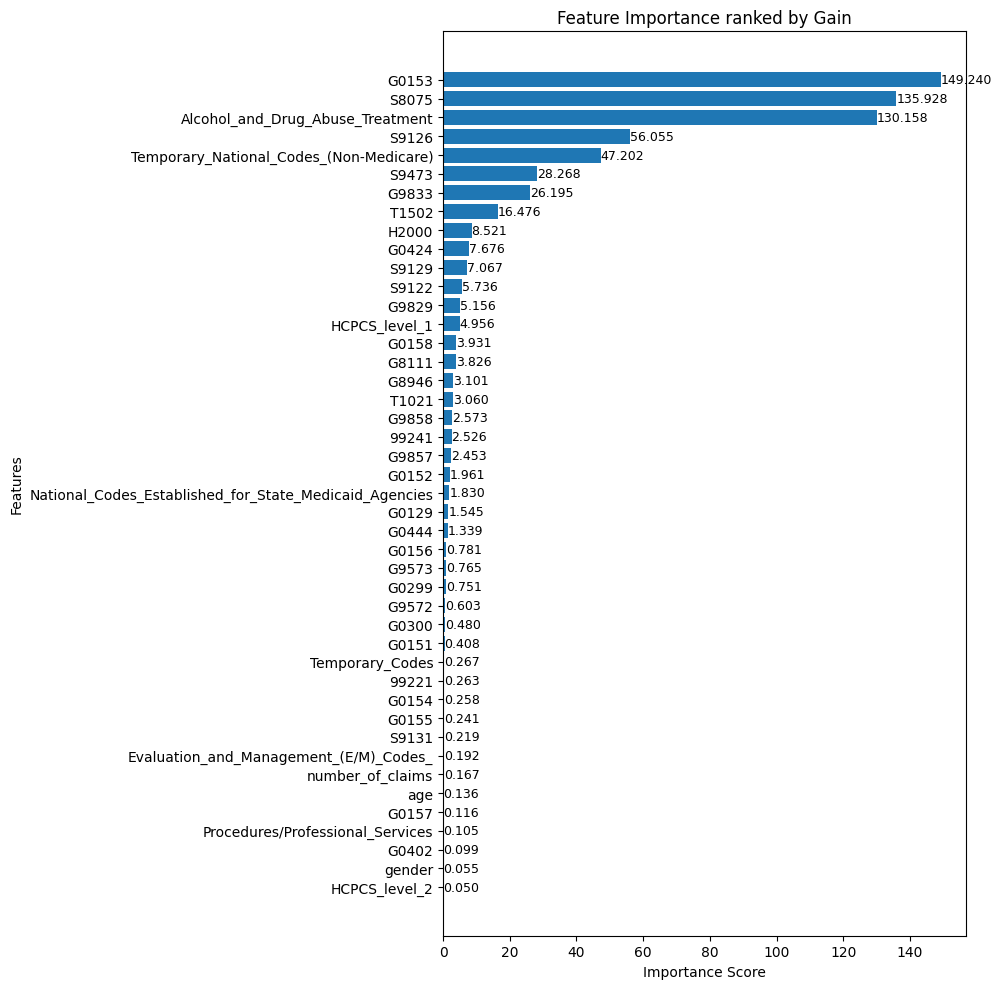

In [37]:
# Feature importance with built in XGBoost module
feature_importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
plot_xgb_importance(feature_importance_gain, "Feature Importance ranked by Gain")

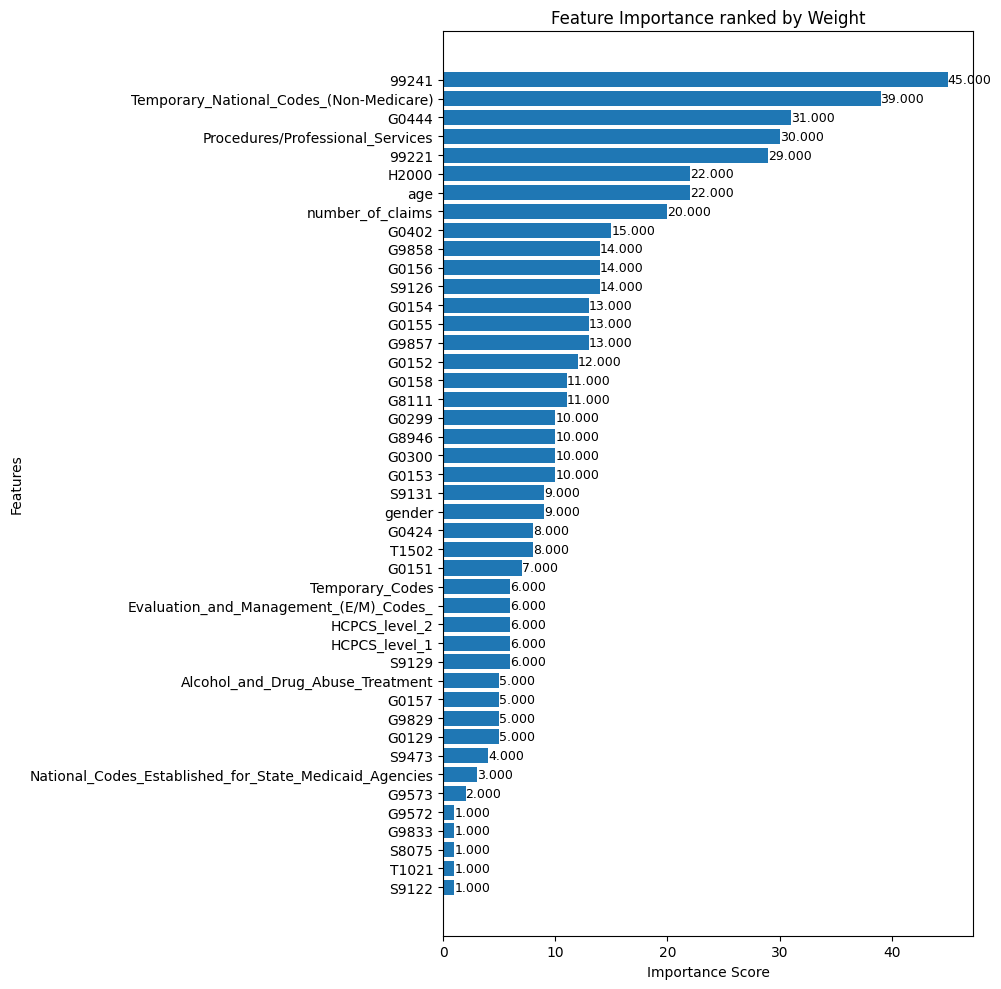

In [38]:
feature_importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
plot_xgb_importance(feature_importance_weight, "Feature Importance ranked by Weight")

## Model 4: FF Neural Network

NOTE: Workflow works, but output needs to be one hot encoded

In [39]:
import tensorflow as tf
import keras.models
from tensorflow import keras
from keras.layers import Input, Dense, ReLU, BatchNormalization, Dropout

In [40]:
# Parameters and Tuning
input_shape = (X_train.shape[1], ) # Number of columns
output_shape = 9 # Number of clusters (targets)
optimizer = "sgd"
loss = "categorical_crossentropy" # If target is label_encoded sparse_categorical_crossentropy
num_epochs = 50 

In [41]:
# Create one-hot encoding
y_train_oh = tf.one_hot(y_train, depth=output_shape)
y_val_oh = tf.one_hot(y_val, depth=output_shape)

In [42]:
inputs = Input(input_shape)

# 2 Layer MLP
dense_layer_1 = Dense(64)(inputs)
batch_norm_1 = BatchNormalization()(dense_layer_1)
relu_1 = ReLU()(batch_norm_1)
dropout_1 = Dropout(rate=0.1)(relu_1)

dense_layer_2 = Dense(64)(dropout_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)
relu_2 = ReLU()(batch_norm_2)
dropout_2 = Dropout(rate=0.1)(relu_2)

outputs = Dense(output_shape, activation='softmax')(dropout_2)

model = keras.Model(inputs=inputs, outputs=outputs)

In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,969 (35.04 KB)

 Trainable params: 8,713 (34.04 KB)

 Non-trainable params: 256 (1.00 KB)

In [44]:
model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=[
    keras.metrics.CategoricalAccuracy(),
    keras.metrics.Precision(),
    keras.metrics.Recall(),
  ]
)

In [45]:
history = model.fit(
  X_train,
  y_train_oh,
  validation_data=[X_val, y_val_oh],
  epochs=num_epochs
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.3535 - loss: 2.0351 - precision: 0.6692 - recall: 0.0854 - val_categorical_accuracy: 0.5134 - val_loss: 2.4242 - val_precision: 0.5115 - val_recall: 0.5096
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - categorical_accuracy: 0.5789 - loss: 1.4420 - precision: 0.7481 - recall: 0.2379 - val_categorical_accuracy: 0.5134 - val_loss: 1.6855 - val_precision: 1.0000 - val_recall: 0.0077
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - categorical_accuracy: 0.6609 - loss: 1.1759 - precision: 0.8239 - recall: 0.4038 - val_categorical_accuracy: 0.2567 - val_loss: 1.5908 - val_precision: 0.9375 - val_recall: 0.1149
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - categorical_accuracy: 0.6724 - loss: 1.0823 - precision: 0.8508 - recall: 0.4758 - val_categorical_accuracy: 0.3487 - val_loss: 1.5600 - val_precision: 0.3333 - val_recall: 0.2835
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - categorical_

In [46]:
history_dict = history.history
history_dict.keys()

dict_keys(['categorical_accuracy', 'loss', 'precision', 'recall', 'val_categorical_accuracy', 'val_loss', 'val_precision', 'val_recall'])

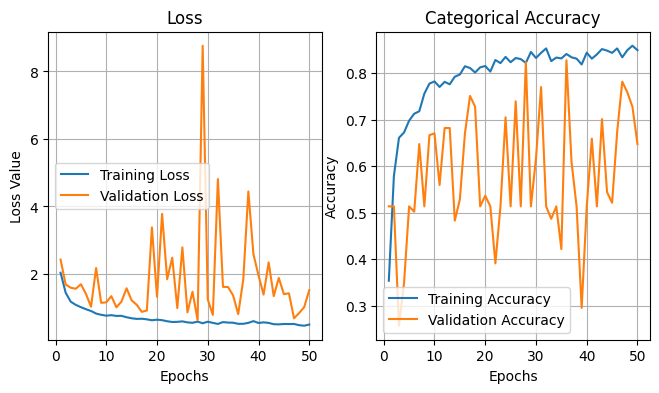

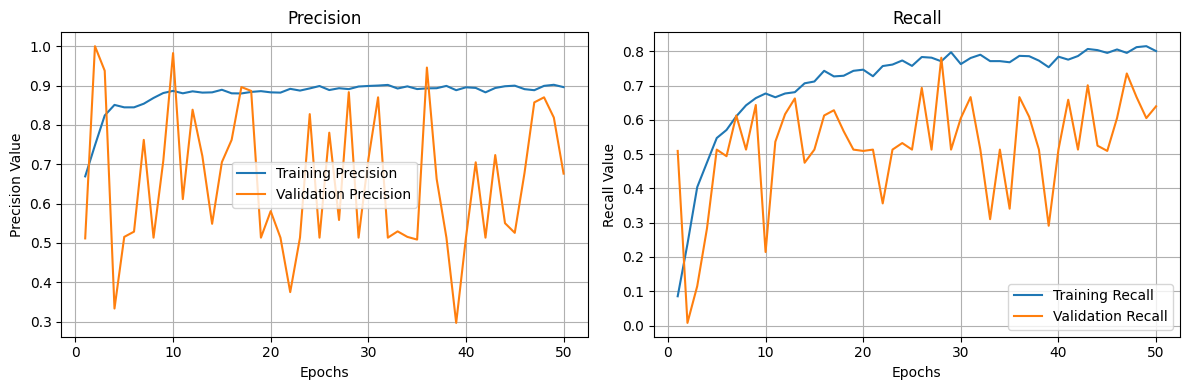

In [47]:
# NOTE: Depending on the run number you have to change precision and recall values
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plotting for Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# Plotting for categorical accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict['categorical_accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Separate Precision and Recall plots
plt.figure(figsize=(12, 4))

# Plotting for Precision
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['precision'], label='Training Precision')
plt.plot(epochs, history_dict['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision Value')
plt.legend()
plt.grid(True)

# Plotting for Recall
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['recall'], label='Training Recall')
plt.plot(epochs, history_dict['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Feature Importance & Model Inspection

Explore the contributing factors of the model and evaluate the model's effectiveness in predictions

## Feature Importance

1. Decision tree visualisation + importance
2. Partial dependence plot
3. Permutation importance

### 1. Decision trees

- Plotted decision tree allows people to trace the path of the decision based on the feature values, making the results understandable
- Feature importance plot shows which feature caused the greatest reduction in variance of gini coefficient compared to their parent node, making that feature more important

In [48]:
from sklearn.tree import plot_tree

In [49]:
ovr = dt_model.estimators_[0]

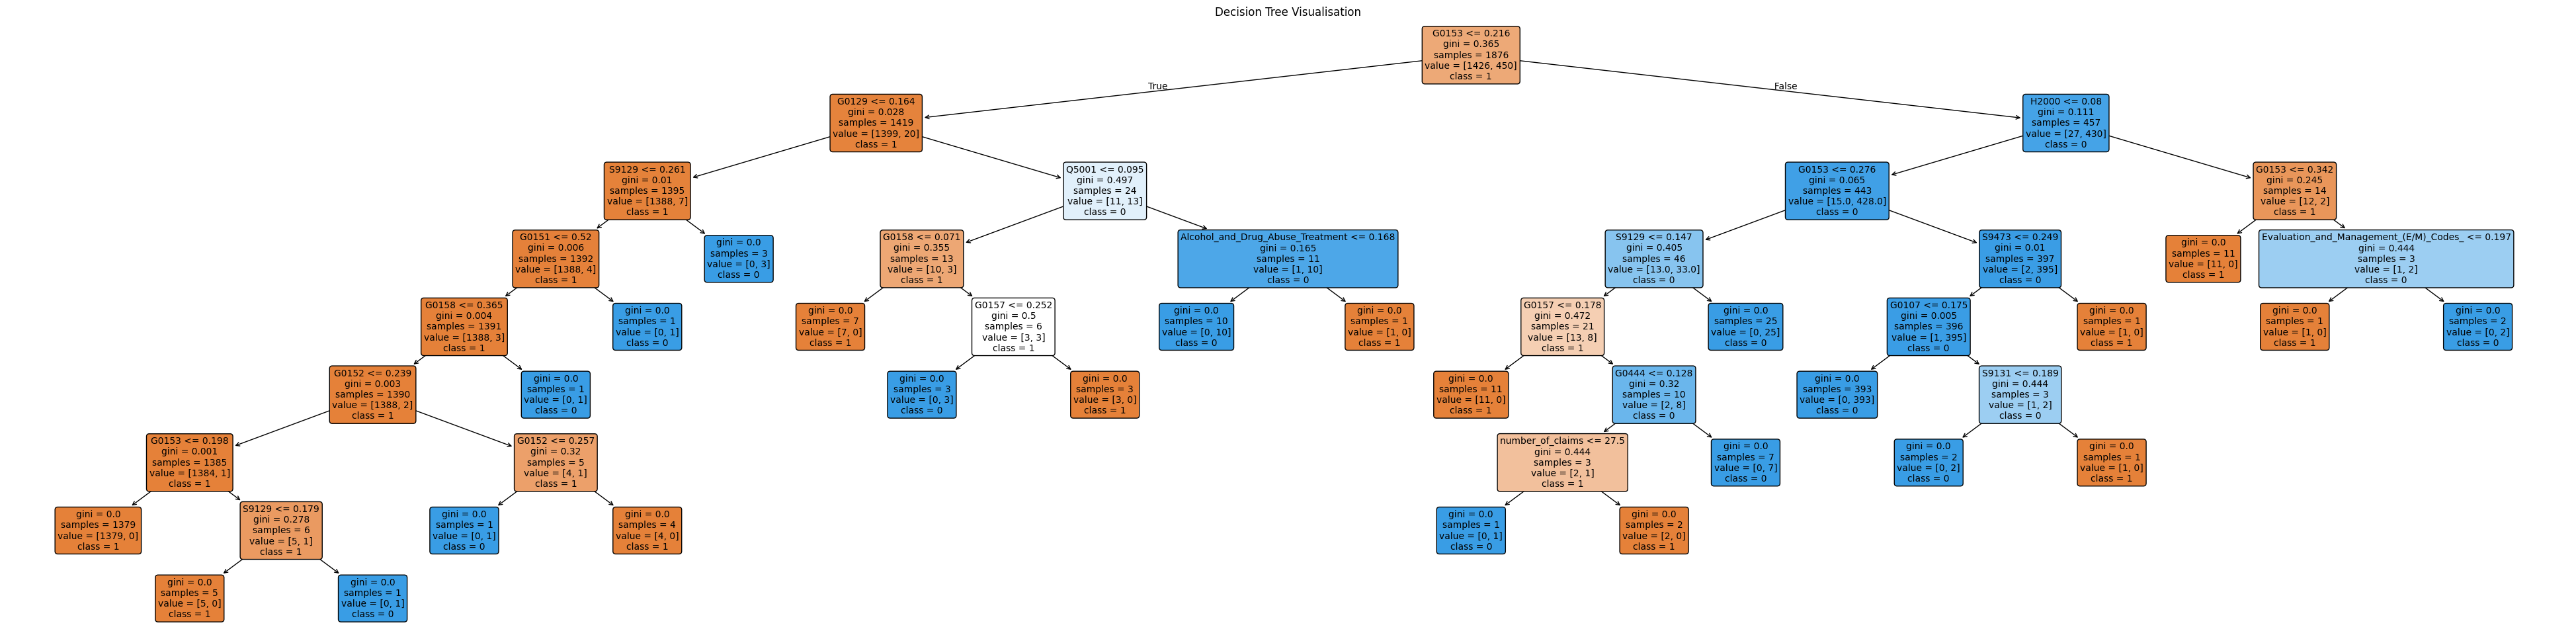

In [50]:
fig, ax = plt.subplots(figsize=(50, 12))
plot_tree(
  ovr,
  feature_names=X_train.columns,
  class_names=y_train.unique().astype(str),
  filled=True,
  rounded=True,
  fontsize=10
)
plt.title("Decision Tree Visualisation")
plt.show()

Text(0.5, 1.0, 'Feature Importance According to Decision Tree Model')

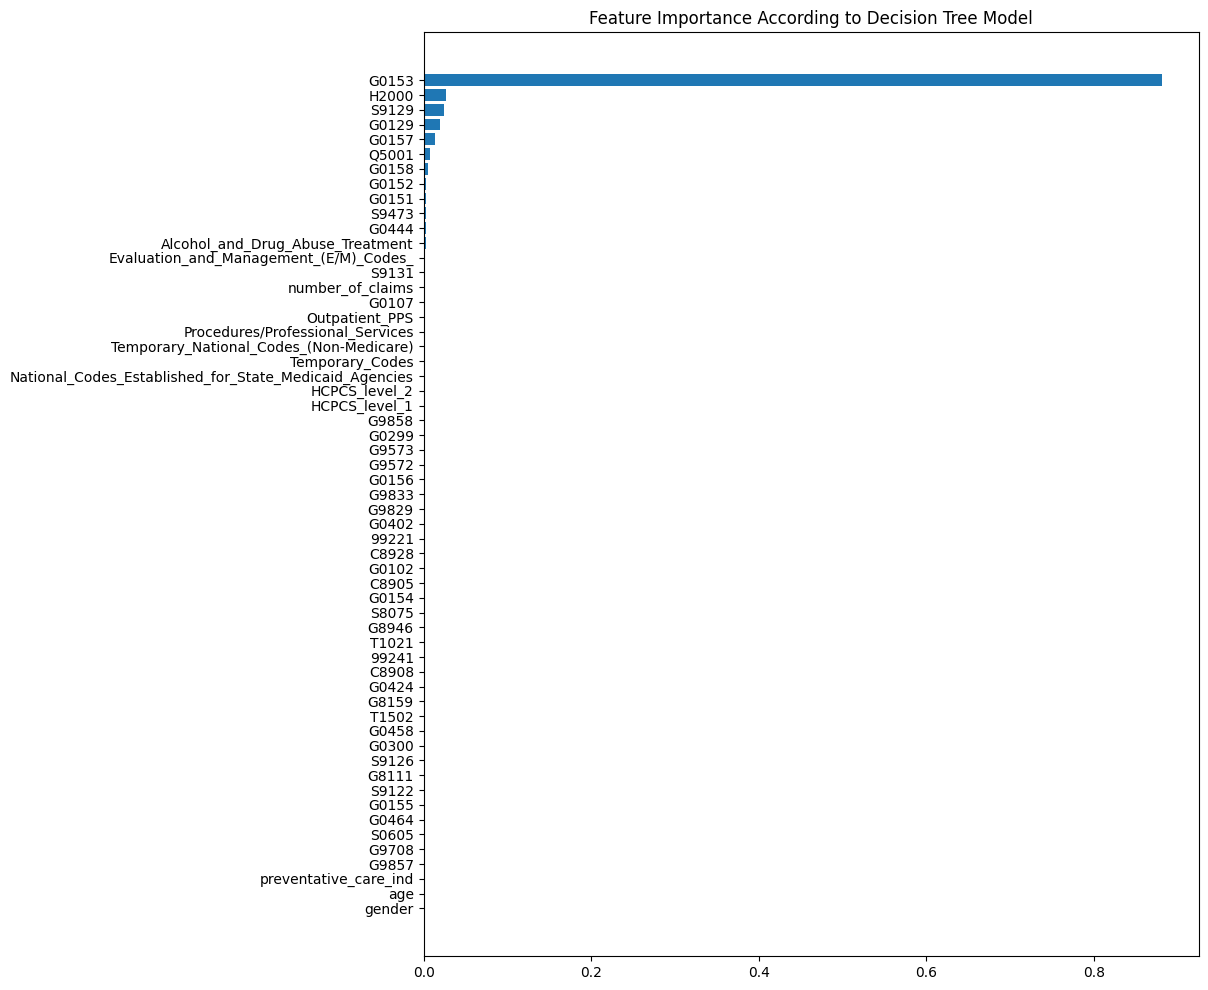

In [51]:
fig, ax = plt.subplots(figsize=(10, 12))
dt_importance = {k: v for k, v in zip(X_train.columns, ovr.feature_importances_)}
dt_importance = dict(sorted(dt_importance.items(), key=lambda kv: kv[1]))
plt.barh(dt_importance.keys(), dt_importance.values())
plt.title("Feature Importance According to Decision Tree Model")

### 2. Partial dependence plot

- PDP plots select a feature (or a set of features) and fix the average of all other features
- It then iterates through the range of the selected feature and produces a predicted value for each entry, with only the selected feature varying
- If there is a large fluctuation, then the feature is important

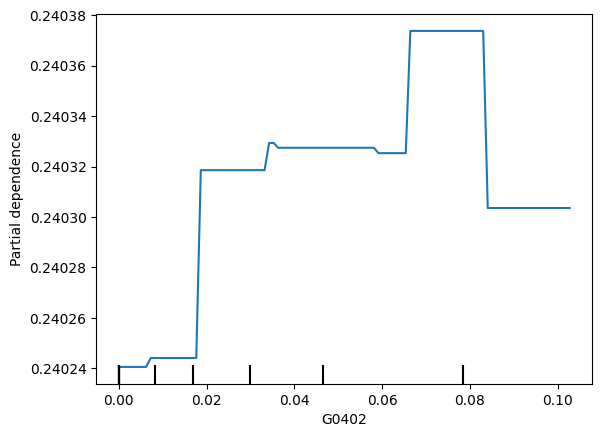

In [52]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
  estimator=xgb_model,
  X=X_train,
  features=['G0402'],
  target=0
  # categorical_features=,
)


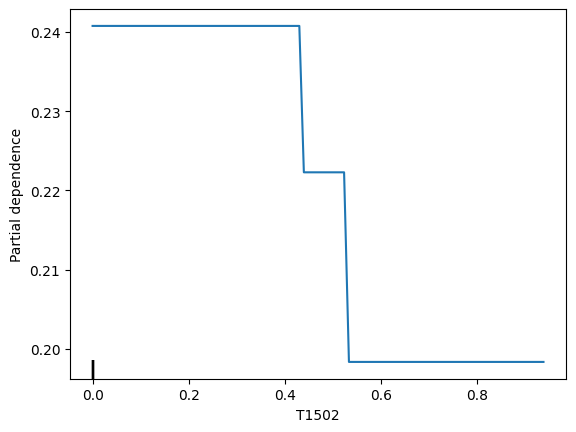

In [53]:
PartialDependenceDisplay.from_estimator(
  estimator=xgb_model,
  X=X_train,
  features=['T1502'],
  target=0
  # categorical_features=,
)

### 3. Permutation importance

- Acts as a form of ablation study
- Similar to PDP plot but feature interactions are preserved (assuming the model automatically accounts for them)
- Select a feature and it randomly shuffles that feature values then makes predictions
- If the deviation from the true value increases significantly from the original model, then that feature is considered important

In [54]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

multiclass_scorer = make_scorer(precision_score, average='weighted')

result = permutation_importance(
  estimator=xgb_model,
  X=X_test,
  y=y_test,
  scoring=multiclass_scorer,
  n_repeats=10,
  random_state=SEED
)

/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Text(0, 0.5, 'Feature')

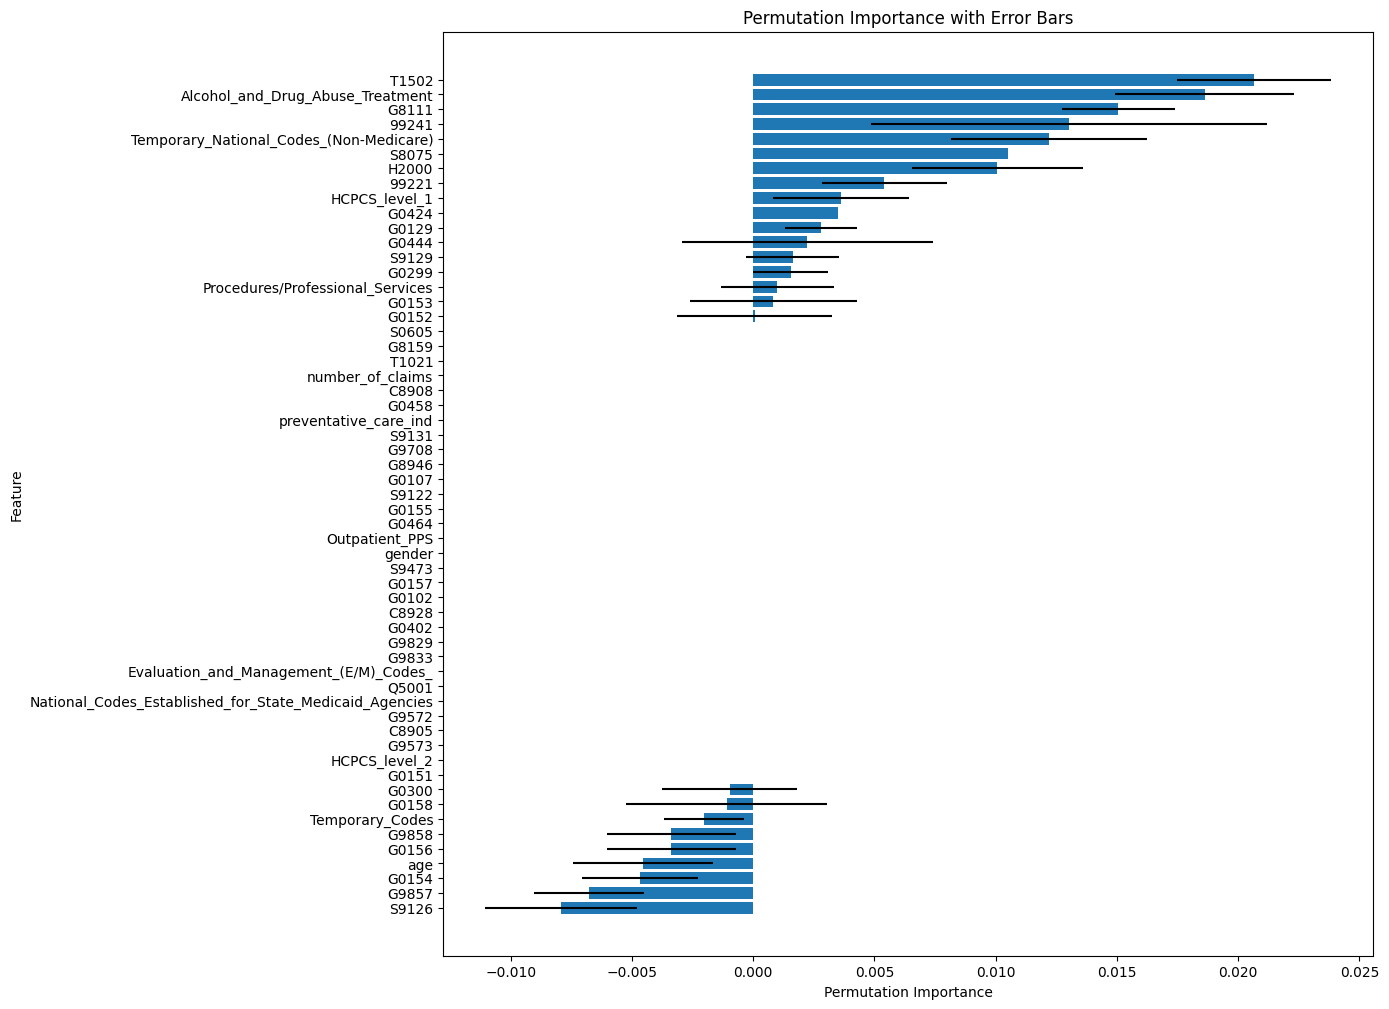

In [55]:
importance_means = result['importances_mean']
importance_std = result['importances_std']

sorted_idx = importance_means.argsort()
df_perm_impt = pd.DataFrame({
  "impt_mean": importance_means[sorted_idx],
  "impt_std": importance_std[sorted_idx],
  "feature": np.array(X_test.columns)[sorted_idx]
})

fig, ax = plt.subplots(figsize=(12, 12))
ax.barh(
  df_perm_impt['feature'],
  df_perm_impt['impt_mean'],
  xerr=df_perm_impt['impt_std'],
  align='center'
)
plt.title("Permutation Importance with Error Bars")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")

Knowing the importance of features above, does the model's performance decrease when removing these features?

In [56]:
features_to_remove = df_perm_impt[df_perm_impt['impt_mean'] == 0].feature.to_list()
cols = [col for col in X_train.columns if col not in features_to_remove]

X_train_removed = X_train[cols]
X_val_removed = X_val[cols]

In [57]:
config = {
  "num_class": 8,
  "n_estimators": 100,
  "max_depth": 2,
  "learning_rate": 1
}

xgb_model = XGBClassifier(**config, objective="multi:softmax", random_state=SEED)

xgb_model.fit(X_train_removed, y_train)
preds = xgb_model.predict(X_val_removed)
acc, prec, recall, f1 = metrics_score(y_val, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 96.93%
Precision: 96.96000000000001%
Recall: 96.93%
F1: 96.93%


We observe a slight dip in accuracy, meaning that there is some interaction happening between the features that individually is not captured with permutation importance

# Training Curves

Training data curves compare models with various sizes of training data to identify the overall impact on the model given a smaller dataset. Here we use varying percentages of training data to predict the validation data

The training data is also sampled from stratification. Data size ranges from 10-100% in increments of 10

In [58]:
type(y_train)

pandas.core.series.Series

In [59]:
def stratify_percentage_sample(X: pd.DataFrame, y: pd.Series, percent: float, seed: int):
  """Stratified sampling based on the percentage value specified from the training dataset

  Args:
      X (pd.DataFrame): Training data
      y (pd.Series): Training data labels
      percent (float): Percentage of training data to use
      seed (int): Seed value

  Returns:
      pd.DataFrame, pd.DataFrame: Output dataframes from stratified sampling
  """
  rng = np.random.default_rng(seed=seed)

  idx = []
  for target in y.unique():
    y_sub = y[y == target]
    size = int(len(y_sub) * percent)
    size = 1 if size < 1 else size # Return at least 1 sample from each class
    indices = y_sub.index.to_series().sample(n=size, random_state=seed).index
    idx.append(list(indices))
  idx = [i for sublist in idx for i in sublist]
  rng.shuffle(idx)

  X_shuffle = X.loc[idx]
  y_shuffle = y.loc[idx]

  return X_shuffle, y_shuffle

In [60]:
# Run the stratified percentage sampling through the basic random forest classifier
percents = np.linspace(0.1, 1, num=10)
results = {
  "percentage": [],
  "accuracy": [],
  "precision": [],
  "recall": [],
  "f1": []
}
for perc in percents:
  # For model tuning
  config = {
    "num_class": 8,
    "n_estimators": 100,
    "max_depth": 2,
    "learning_rate": 1
  }

  xgb_model = XGBClassifier(**config, objective="multi:softmax", random_state=SEED)

  X_sampled, y_sampled = stratify_percentage_sample(X_train, y_train, percent=perc, seed=SEED)
  xgb_model.fit(X_sampled, y_sampled)
  preds = xgb_model.predict(X_val)
  acc, prec, recall, f1 = metrics_score(y_val, preds)

  # Adding results
  results['percentage'].append(perc)
  results['accuracy'].append(acc * 100)
  results['precision'].append(prec * 100)
  results['recall'].append(recall * 100)
  results['f1'].append(f1 * 100)

/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Text(0.5, 1.0, 'Metric Scores over Percentage of Data')

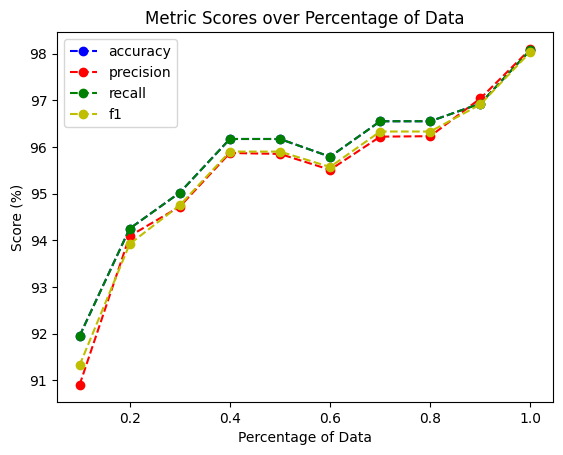

In [61]:
plt.plot(results['percentage'], results['accuracy'], 'bo--', label="accuracy")
plt.plot(results['percentage'], results['precision'], 'ro--', label="precision")
plt.plot(results['percentage'], results['recall'], 'go--', label="recall")
plt.plot(results['percentage'], results['f1'], 'yo--', label="f1")
plt.legend()
plt.ylabel("Score (%)")
plt.xlabel("Percentage of Data")
plt.title("Metric Scores over Percentage of Data")

# Sensitivity Analysis

Sensitivity analysis finds the optimal set of hyperparameters that return the best results and observe if any range of hyperparameters will cause significant impact on performance. Employing 2 methods:

- Grid Search: Manually select a range of values for each hyperparamter and test a permuation of those selected
- Optuna: Package that uses algorithms to search for the best hyperparameter combination from a range provided

<u>Findings from GridSearch</u>

- n_estimators: 100
- learning_rate: 0.1
- max_depth: 10
- reg_alpha: 0

<u>From single parameter analysis</u>

Greatest fluctuation happens from `learning_rate` parameter, but note this is in isolation from changes to other parameters

<u>From Optuna</u>

- n_estimators: 179
- learning_rate: 0.1586578843283348 
- max_depth: 9
- colsample_bytree: 0.43683754489278315
- gamma: 0.17850655983156485 
- reg_alpha: 0
- reg_lambda: 5


In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import optuna

/Users/martz/Repos/siads_696_mII/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
# NOTE: uncomment the various return lines to choose the scoring metric
def custom_scorer(y_true, y_pred):
  return precision_score(y_true, y_pred, average='weighted')
  # return recall_score(y_true, y_pred, average='weighted')
  # return f1_score(y_true, y_pred, average='weighted')

scorer = make_scorer(custom_scorer, greater_is_better=True)

In [ ]:
params = {
  "n_estimators": [10, 50, 100, 300],
  "learning_rate": [0.01, 0.1, 1],
  "max_depth": [3, 5, 10],
  # "colsample_bytree": [0.5, 0.7, 1.0],
  # "gamma": [0, 0.1, 0.4],
  "reg_alpha": [0, 2, 5],
  # "reg_lambda": [0, 2, 5]
}

xgb_model_grid = XGBClassifier(num_class=8, objective="multi:softmax", random_state=SEED)
clf = GridSearchCV(
  xgb_model_grid,
  param_grid=params,
  scoring=scorer,
  cv=5,
  verbose=4
)
clf.fit(X_strat, y_strat)

In [85]:
gs_results = pd.DataFrame(clf.cv_results_)
gs_results[gs_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
66,0.578519,0.01606,0.002545,0.000034,0.1,10,100,0,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.970957,0.989741,0.981062,0.979158,0.985186,0.981221,0.006292,1


In [88]:
gs_results[gs_results['rank_test_score'] == gs_results['rank_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.049604,0.001429,0.001977,0.000071,0.01,3,10,5,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.952814,0.956449,0.970507,0.951637,0.955312,0.957344,0.006801,108


What if we want to observe how a single component affects the model

In [66]:
def single_component_analysis(clf, param: dict, seed: int):
  """Perform a fit on a single model parameter

  Args:
      clf (model object): Classifer model object
      param (dict): Model parameters
      seed (int): Seed value

  Returns:
      pd.DataFrame: results of the GridSearch cross validation
  """
  model = clf(random_state=seed)

  search = GridSearchCV(
    model,
    param_grid=param,
    cv=5,
    verbose=2
  )
  search.fit(X_strat, y_strat)

  return pd.DataFrame(search.cv_results_)

def plot_search_performance(res: pd.DataFrame, param: str):
  """Plots the performance impact of a single model parameter

  Args:
      res (pd.DataFrame): Results dataframe
      param (str): parameter selected
  """
  plt.errorbar(
    x=res[f"param_{param}"],
    y=res["mean_test_score"],
    yerr=res["std_test_score"],
    fmt='o',
    capsize=5,
    ecolor='red',
    elinewidth=1
  )

  plt.title(f"Change in Performance with varying {param}")
  plt.xlabel(f"{param}")
  plt.ylabel("Performance")
  plt.show()

In [91]:
explore = {
  "reg_alpha": np.linspace(1, 20, 20, dtype=int),
}

out = single_component_analysis(
  XGBClassifier,
  param=explore,
  seed=SEED
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................................reg_alpha=1; total time=   0.4s
[CV] END ........................................reg_alpha=1; total time=   0.4s
[CV] END ........................................reg_alpha=1; total time=   0.4s
[CV] END ........................................reg_alpha=1; total time=   0.3s
[CV] END ........................................reg_alpha=1; total time=   0.4s
[CV] END ........................................reg_alpha=2; total time=   0.3s
[CV] END ........................................reg_alpha=2; total time=   0.3s
[CV] END ........................................reg_alpha=2; total time=   0.3s
[CV] END ........................................reg_alpha=2; total time=   0.3s
[CV] END ........................................reg_alpha=2; total time=   0.3s
[CV] END ........................................reg_alpha=3; total time=   0.3s
[CV] END ......................................

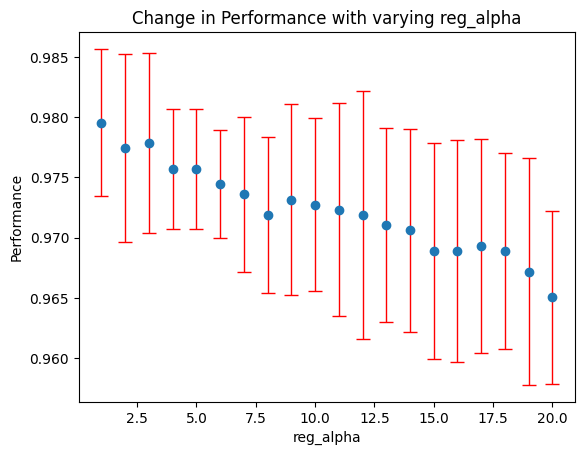

In [92]:
plot_search_performance(out, list(explore.keys())[0])

Using Optuna

In [69]:
param_distribution = {
  "n_estimators": optuna.distributions.IntDistribution(10, 400),
  "learning_rate": optuna.distributions.FloatDistribution(0.001, 1.0),
  "max_depth": optuna.distributions.IntDistribution(1, 10),
  "colsample_bytree": optuna.distributions.FloatDistribution(0.1, 1.0),
  "gamma": optuna.distributions.FloatDistribution(0.0, 1.0),
  "reg_alpha": optuna.distributions.IntDistribution(0, 10),
  "reg_lambda": optuna.distributions.IntDistribution(0, 10),
}

In [70]:
optuna_xgb = XGBClassifier(num_class=8, objective="multi:softmax", random_state=SEED)

optuna_search = optuna.integration.OptunaSearchCV(
  optuna_xgb,
  param_distribution,
  n_trials=100,
  timeout=600,
  verbose=2,
  random_state=SEED
)
optuna_search.fit(X_strat, y_strat)

/var/folders/df/6w983x9x0cg5pppshqj46f500000gn/T/ipykernel_13886/2270335574.py:3: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2025-10-16 12:23:14,545] A new study created in memory with name: no-name-b8ee8ca5-df2e-40b5-8ee7-1efc1fedac5c
[I 2025-10-16 12:23:15,651] Trial 0 finished with value: 0.9688844531143672 and parameters: {'n_estimators': 105, 'learning_rate': 0.36549909330622926, 'max_depth': 3, 'colsample_bytree': 0.7186093041484938, 'gamma': 0.7495389882399229, 'reg_alpha': 9, 'reg_lambda': 8}. Best is trial 0 with value: 0.9688844531143672.
[I 2025-10-16 12:23:16,370] Trial 1 finished with value: 0.9714430885088238 and parameters: {'n_estimators': 50, 'learning_rate': 0.4395323811673451, 'max_depth': 10, 'colsample_bytree': 0.7866242677922363, 'gamma': 0.25280151723002453, 'reg_alpha': 7, 'reg_lambda': 3}. Best is trial 1 with value: 0.9714430885088

,estimator,"XGBClassifier..._class=8, ...)"
,param_distributions,"{'colsample_bytree': FloatDistribu....1, step=None), 'gamma': FloatDistribu....0, step=None), 'learning_rate': FloatDistribu...01, step=None), 'max_depth': IntDistributi...low=1, step=1), ...}"
,cv,None
,enable_pruning,False
,error_score,nan
,max_iter,1000
,n_jobs,1
,n_trials,100
,random_state,43
,refit,True
,return_train_score,False


In [71]:
print(f"Best trial: {optuna_search.study_.best_trial.params}")

Best trial: {'n_estimators': 179, 'learning_rate': 0.1586578843283348, 'max_depth': 9, 'colsample_bytree': 0.43683754489278315, 'gamma': 0.17850655983156485, 'reg_alpha': 0, 'reg_lambda': 5}


In [72]:
# Plotting feature importance from Optuna
optuna.visualization.plot_param_importances(optuna_search.study_)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [max_depth (IntDistribution):
                                0.003987676063060738<extra></extra>, reg_lambda
                                (IntDistribution):
                                0.005652132919393364<extra></extra>, gamma
                                (FloatDistribution):
                                0.008084825523596552<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.014723734121174644<extra></extra>, n_estimators
                                (IntDistribution):
                                0.028329227774849076<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.4451351115608187<extra></extra>, reg_alpha
                                (IntDistribution):
                                0.49408729203710694<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, <0.01, 0.01, 0.03, 0.45, 0.49],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.003987676063060738, 0.005652132919393364,
                    0.008084825523596552, 0.014723734121174644,
                    0.028329227774849076, 0.4451351115608187, 0.49408729203710694],
              'y': [max_depth, reg_lambda, gamma, colsample_bytree, n_estimators,
                    learning_rate, reg_alpha]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

# Failure Analysis

Rerunning the XGBoost model with optimal configuration as found by Optuna on the Training and Validation sets. Then evaluate the model on the Test set.

In [19]:
config = {
  'n_estimators': 179,
  'learning_rate': 0.1586578843283348,
  'max_depth': 9,
  'colsample_bytree': 0.43683754489278315,
  'gamma': 0.17850655983156485,
  'reg_alpha': 0,
  'reg_lambda': 5
}

xgb_model_final = XGBClassifier(**config, num_class=8, objective="multi:softmax", random_state=SEED)

xgb_model_final.fit(X_strat, y_strat)
preds = xgb_model_final.predict(X_test)
acc, prec, recall, f1 = metrics_score(y_test, preds)
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1: {f1 * 100}%")

Accuracy: 97.7%
Precision: 97.85000000000001%
Recall: 97.7%
F1: 97.72%


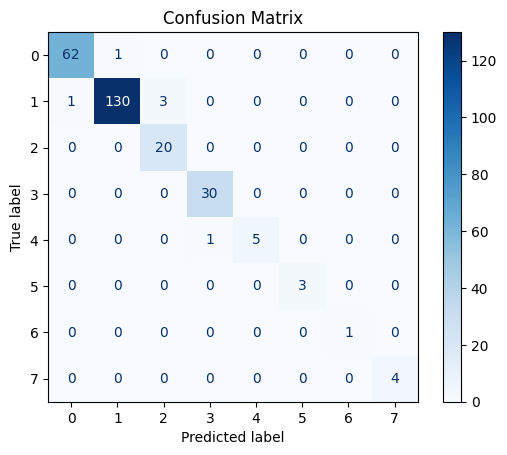

In [20]:
plot_confusion_matrix(clf=xgb_model_final, y_true=y_test, y_pred=preds)

Get the entries that were wrongly predicted

In [33]:
df_fail = X_test.copy()
df_fail['target'] = y_test
df_fail['predicted'] = preds
df_fail = df_fail.reset_index(drop=True)

df_fail[df_fail['target'] != df_fail['predicted']]

,gender,age,number_of_claims,preventative_care_ind,G9857,G9708,S0605,G0153,G0464,G0155,...,HCPCS_level_2,National_Codes_Established_for_State_Medicaid_Agencies,Evaluation_and_Management_(E/M)_Codes_,Temporary_Codes,Temporary_National_Codes_(Non-Medicare),Procedures/Professional_Services,Alcohol_and_Drug_Abuse_Treatment,Outpatient_PPS,target,predicted
98,1,73.0,43,1,0.000000,0.0,0.0,0.193612,0.000000,0.263374,...,0.731339,0.0,0.743291,0.048835,0.271355,0.609508,0.000000,0.0,1,0
119,1,77.0,39,1,0.000000,0.0,0.0,0.000000,0.000000,0.077353,...,0.517980,0.0,0.865357,0.000000,0.000000,0.489080,0.109354,0.0,1,2
146,0,77.0,62,1,0.000000,0.0,0.0,0.000000,0.000000,0.099885,...,0.630828,0.0,0.803844,0.000000,0.074530,0.585921,0.070542,0.0,1,2
234,1,79.0,36,1,0.000000,0.0,0.0,0.087387,0.000000,0.071325,...,0.392689,0.0,0.935212,0.075625,0.000000,0.326720,0.113636,0.0,1,2
252,0,75.0,36,1,0.331708,0.0,0.0,0.000000,0.065664,0.174654,...,0.920448,0.0,0.444522,0.000000,0.459250,0.769084,0.000000,0.0,4,3
253,0,78.0,99,1,0.153633,0.0,0.0,0.089199,0.000000,0.145607,...,0.808113,0.0,0.655022,0.043036,0.273292,0.702395,0.032334,0.0,0,1


In [22]:
shap_pred = df_fail['predicted']
shap_actl = df_fail['target']
X_shap = df_fail.drop(['predicted', 'target'], axis=1)

## Analysis for single instances

Based on the results of the model above, we observe that entries (104, 174, 246) were wrongly predicted, so using SHAP values, we analyses why they were wrongly predicted

In [23]:
import shap

In [24]:
explainer = shap.TreeExplainer(xgb_model_final)
shap_values = explainer.shap_values(X_shap)

In [65]:
def plot_single_shap(entry_idx):
  wrong_instance = X_shap.loc[[entry_idx]]
  wrong_instance_preds = shap_pred.loc[entry_idx]
  wrong_instance_actl = shap_actl.loc[entry_idx]

  base_value_preds = round(explainer.expected_value[wrong_instance_preds], 3)
  base_value_actl = explainer.expected_value[wrong_instance_actl]
  single_entry_shap_values = shap_values[entry_idx][:, wrong_instance_preds]

  # shap.initjs()
  out = shap.force_plot(
    base_value=base_value_actl,
    shap_values=single_entry_shap_values,
    features=wrong_instance.round(4),
    matplotlib=True,
    show=False,
    text_rotation=30
  )

  return out

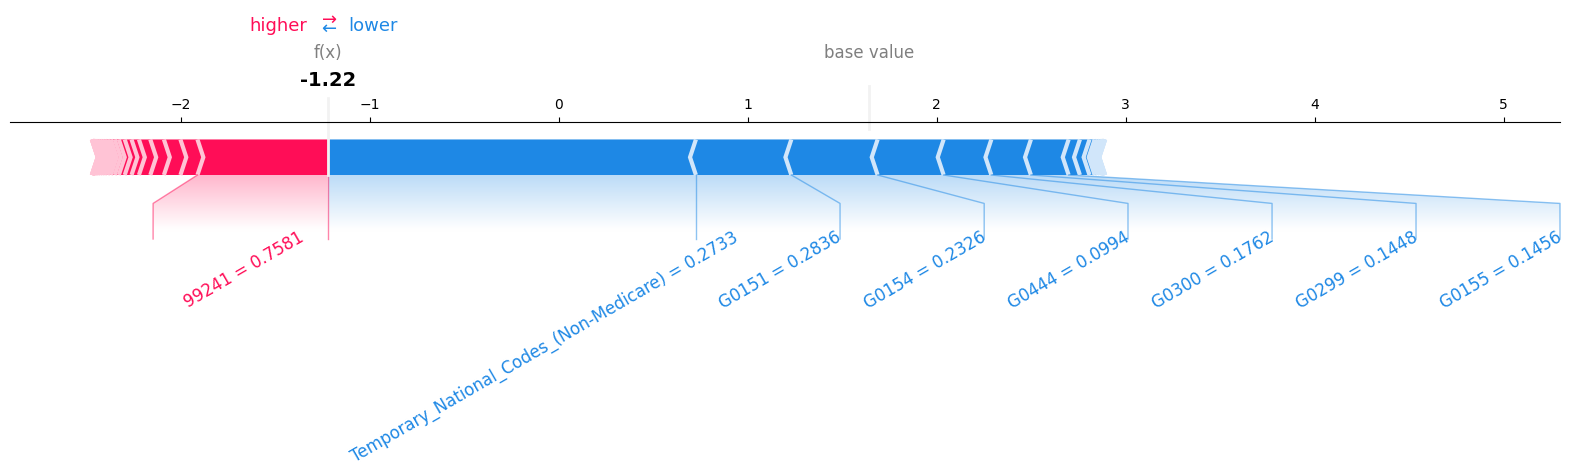

In [66]:
ENTRY_NO = 253
plot_single_shap(entry_idx=ENTRY_NO)

In [67]:
# Also plot for entries that were correctly predicted
correct = df_fail.loc[ENTRY_NO, 'target']
right = df_fail[(df_fail['target'] == correct) & (df_fail['predicted'] == correct)]
right.head()

,gender,age,number_of_claims,preventative_care_ind,G9857,G9708,S0605,G0153,G0464,G0155,...,HCPCS_level_2,National_Codes_Established_for_State_Medicaid_Agencies,Evaluation_and_Management_(E/M)_Codes_,Temporary_Codes,Temporary_National_Codes_(Non-Medicare),Procedures/Professional_Services,Alcohol_and_Drug_Abuse_Treatment,Outpatient_PPS,target,predicted
0,0,71.0,31,1,0.0,0.0,0.0,0.416282,0.0,0.184873,...,0.999506,0.0,0.037808,0.146430,0.335419,0.929851,0.0,0.0,0,0
5,1,72.0,16,1,0.0,0.0,0.0,0.457030,0.0,0.118276,...,0.999617,0.0,0.033789,0.181544,0.363402,0.913148,0.0,0.0,0,0
20,0,79.0,18,1,0.0,0.0,0.0,0.482962,0.0,0.084469,...,0.996608,0.0,0.097183,0.136215,0.270315,0.948120,0.0,0.0,0,0
25,0,74.0,11,1,0.0,0.0,0.0,0.536373,0.0,0.202054,...,0.999816,0.0,0.023256,0.166241,0.341545,0.924754,0.0,0.0,0,0
28,0,75.0,16,1,0.0,0.0,0.0,0.240405,0.0,0.098108,...,0.978618,0.0,0.239565,0.143907,0.228463,0.932579,0.0,0.0,0,0


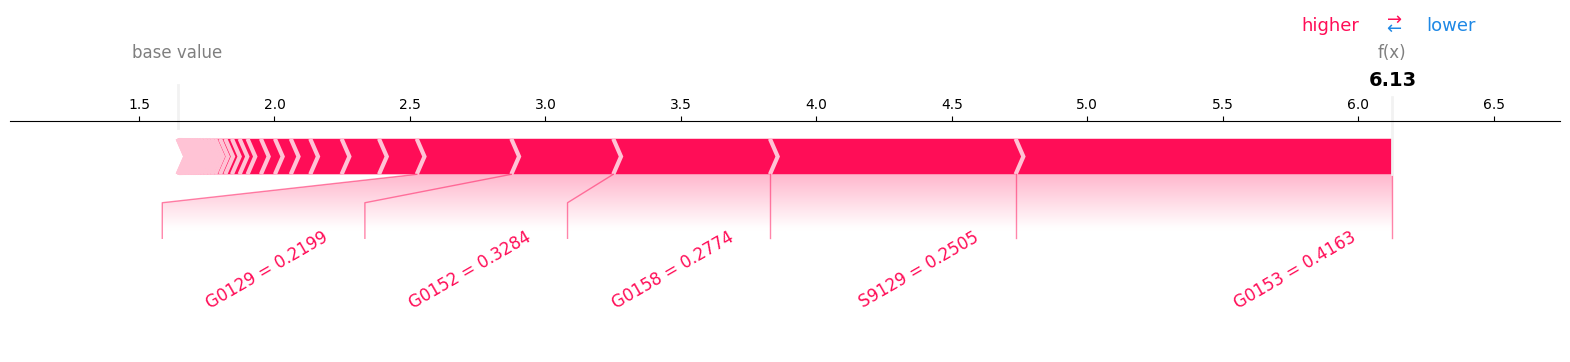

In [68]:
RIGHT_ENTRY_NO = 0
plot_single_shap(entry_idx=RIGHT_ENTRY_NO)

In [83]:
df_fail.loc[ENTRY_NO, '99241']

np.float64(0.7581301128127024)

In [84]:
df_fail.loc[RIGHT_ENTRY_NO, '99241']

np.float64(0.048247045380747214)

Text(0.5, 1.0, 'Difference between Incorrect Entry and Mean of Correctly Predicted')

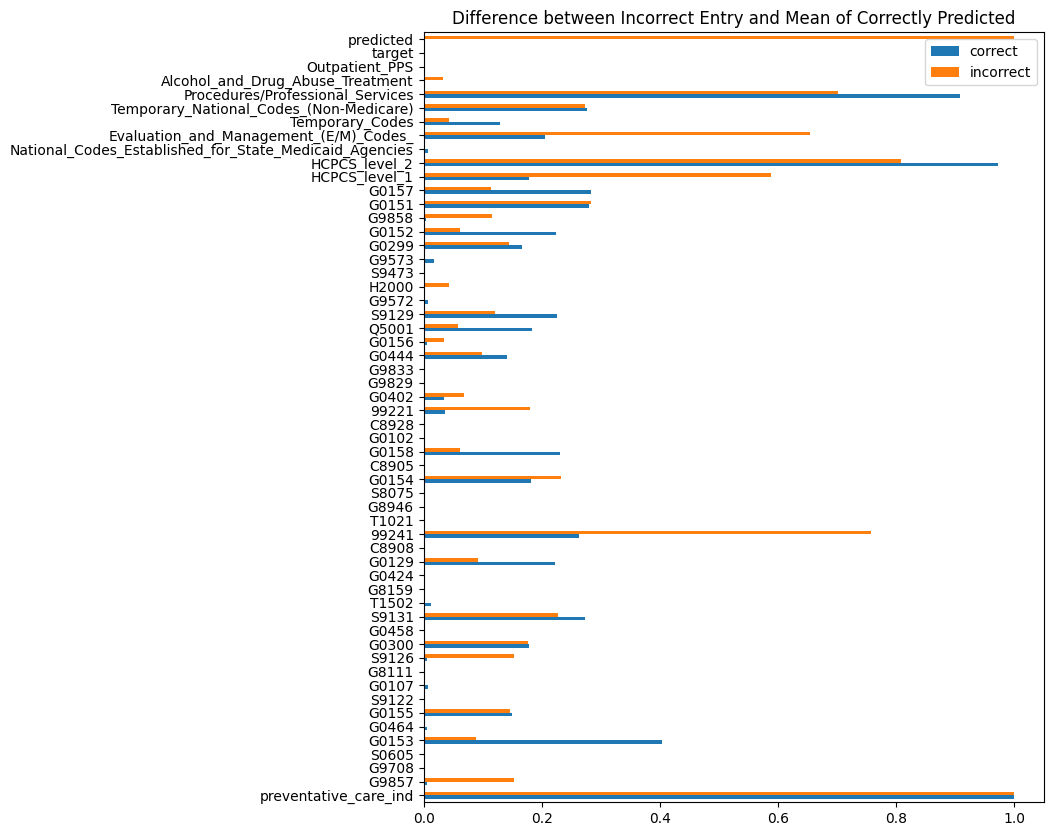

In [45]:
# Compare entry to the mean
series_1 = right.mean()
series_2 = df_fail[df_fail['target'] != df_fail['predicted']].loc[ENTRY_NO]

# Drop age and gender
series_1 = series_1.drop(['age', 'gender', 'number_of_claims'])
series_2 = series_2.drop(['age', 'gender', 'number_of_claims'])

p = pd.DataFrame({
  "correct": series_1,
  "incorrect": series_2
})

p.plot.barh(figsize=(8, 10))
plt.title("Difference between Incorrect Entry and Mean of Correctly Predicted")

We observe that many features contributed negatively from the mean of the class for the wrongly predicted entry. Particularly, the HCPCS code "99241" has a much higher value for the values that were predicted correctly over those that were incorrect. This was identified from the SHAP plot above as well.

This also corresponds to the permutation importance plot above where key contributing values are differ significantly causing the model to predict incorrectly